In [20]:
# Import Libraries

# Data Transformations
import numpy as np
import pandas as pd
import itertools
import warnings

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import periodogram

# Model Building
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Data Preparation

In [7]:
# load File
base_df = pd.read_csv('Nat_Gas.csv')

clean_df = base_df.copy() # Preserve original loaded dataset through copy
clean_df['Dates'] = pd.to_datetime(clean_df['Dates'], format='%m/%d/%y') # Parse date column from object to datetime
clean_df = clean_df.set_index('Dates') 
y = clean_df['Prices'] # Load Prices column as a series with index of dates

### EDA

<Axes: xlabel='Dates'>

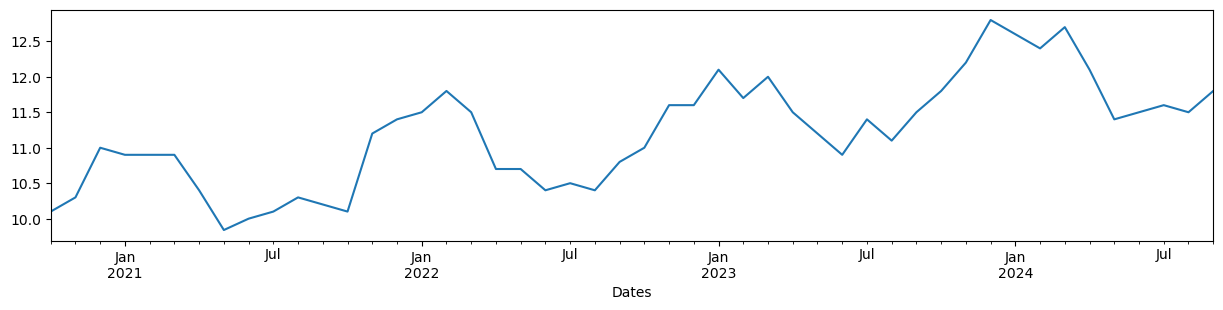

In [8]:
# Visualize and inspect data
fig, ax = plt.subplots(figsize=(15,3))
y.plot(kind='line', ax=ax)

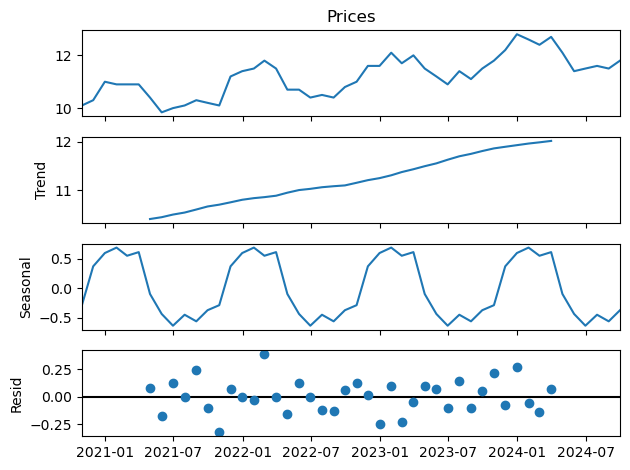

In [9]:
# Visualize and inspect data using seasonal decompose
seasonal_decompose(y, period=12).plot()
plt.show()

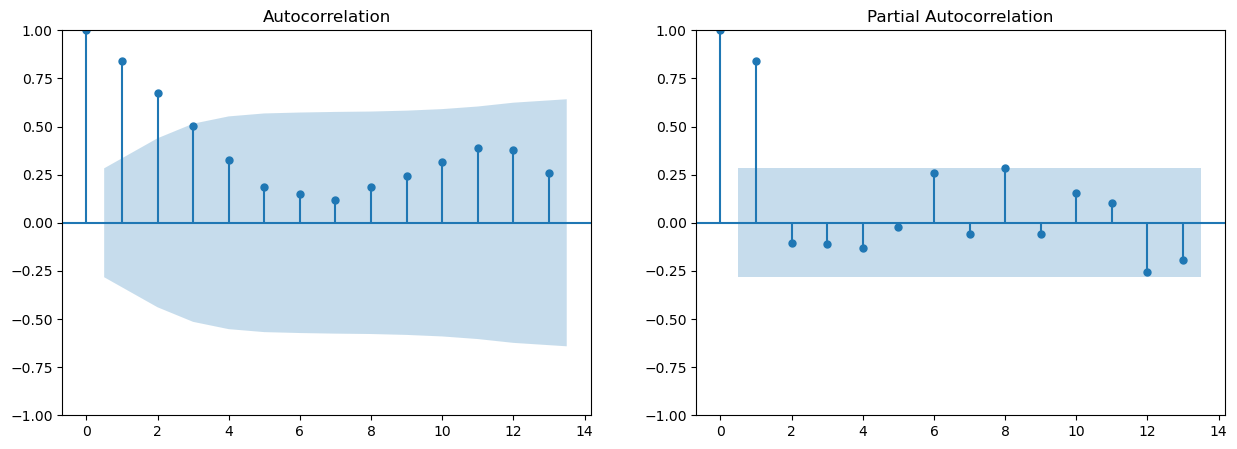

In [10]:
# Visualize ACF and PACF 
fig,ax = plt.subplots(1,2,figsize=(15,5))
lags = 13
plot_acf(y, lags=lags, ax=ax[0])
plot_pacf(y, lags=lags,ax=ax[1])
plt.show()

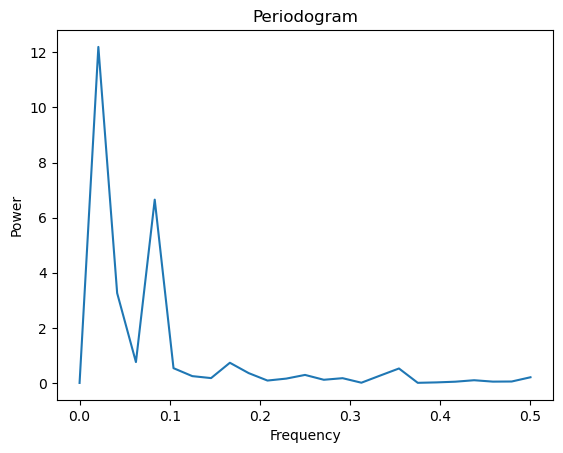

In [21]:
# Check for Seasonality using Periodgram
freqs, spectrum = periodogram(y)
plt.plot(freqs, spectrum)
plt.title("Periodogram")
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.show()

## Model Building

### Baseline Values

In [12]:
# Split data into train and test
cutoff = 0.75
y_train = y.iloc[:int(len(y) * cutoff)]
y_test = y.iloc[int(len(y) * cutoff):]

# Training Baselines
y_train_mean = y_train.mean()
y_train_mae = mean_absolute_error(y_train, [y_train_mean]*len(y_train))
y_train_mse = mean_squared_error(y_train, [y_train_mean]*len(y_train))

print(f'Mean Price: {y_train_mean}')
print(f'Baseline MAE: {y_train_mae}')
print(f'Baseline MSE: {y_train_mse}')

Mean Price: 10.931666666666665
Baseline MAE: 0.5145370370370368
Baseline MSE: 0.3690972222222222


### Hyperparameter Tuning

In [13]:
# Define parameter ranges
p = d = q = range(0, 3)      # ARIMA parameters
P = D = Q = range(0, 3)      # Seasonal parameters
s = 12                       # Seasonality (e.g., monthly data = 12)

# Build parameter combinations
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q))

best_aic = float("inf")
best_order = None
best_seasonal_order = None
best_model = None

warnings.filterwarnings("ignore")

# Iterate through parameter combinations
for order in itertools.product(p, d, q):
    for seasonal_order in itertools.product(P, D, Q):
        try:
            model = SARIMAX(y_train,
                            order=order,
                            seasonal_order=(seasonal_order[0], seasonal_order[1], seasonal_order[2], s),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
                best_seasonal_order = seasonal_order
                best_model = results
        except:
            continue

print(f"Best AIC: {best_aic}")
print(f"Best order: {best_order}")
print(f"Best seasonal_order: {best_seasonal_order + (s,)}")

Best AIC: -4.917296123398939
Best order: (1, 1, 0)
Best seasonal_order: (2, 0, 0, 12)


### Model Training

In [14]:
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = SARIMAX(history, order=best_order, seasonal_order=(best_seasonal_order[0], best_seasonal_order[1], best_seasonal_order[2], s)).fit()
    next_pred = model.forecast()
    y_pred_wfv = pd.concat([y_pred_wfv,next_pred])
    history = pd.concat([history,y_test[next_pred.index]])

### Model Evaluation

Baseline MAE: 0.5145370370370368
Test (WFV) MAE: 0.23407129177457234 

Baseline MSE: 0.3690972222222222
Test (WFV) MSE: 0.10473492755693527 



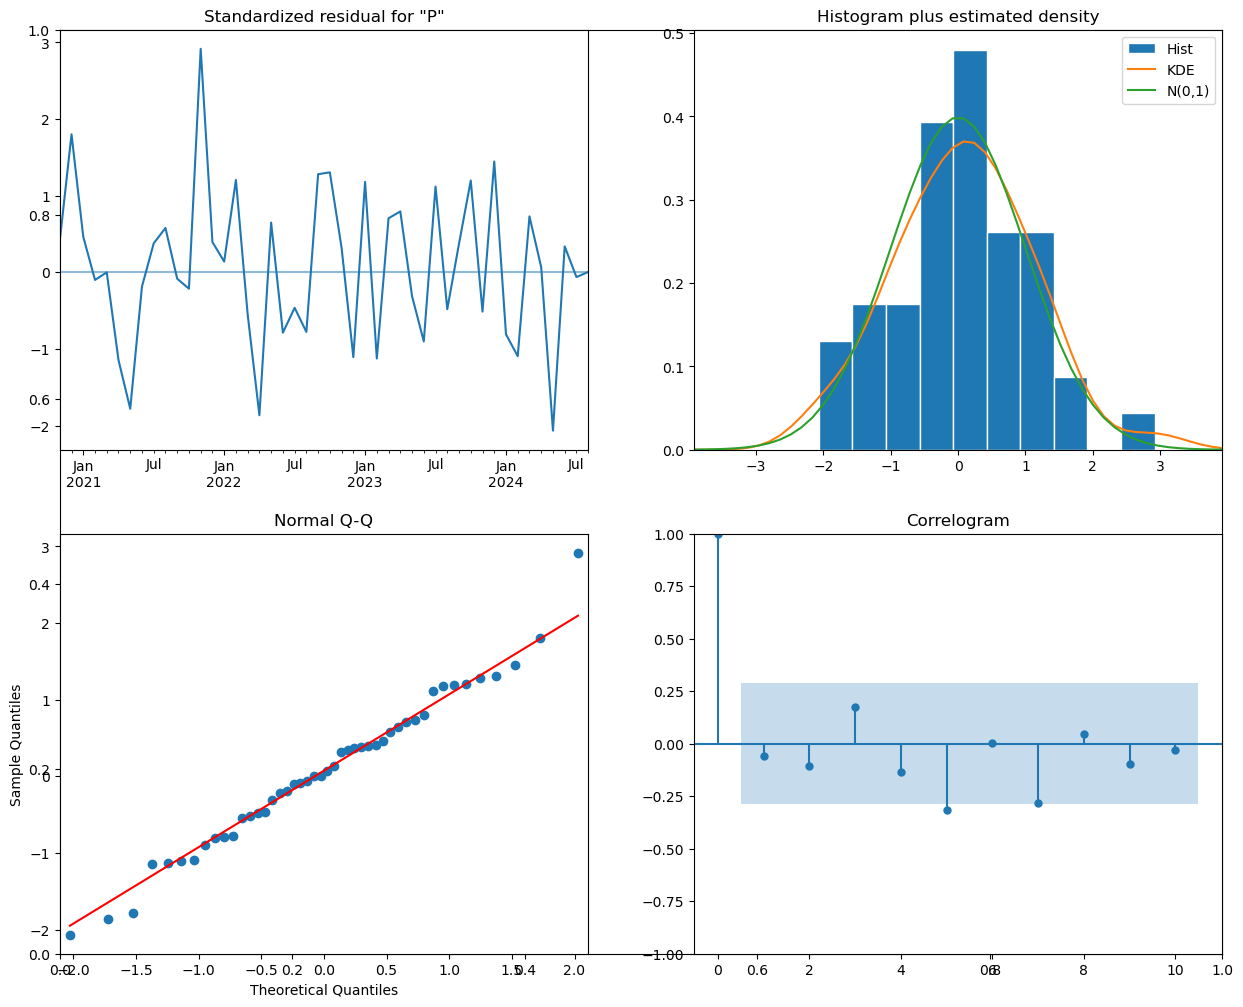

In [ ]:
# Calculate and Compare Test MAE and MSE to Baseline
test_mae = mean_absolute_error(y_test, y_pred_wfv)
test_mse = mean_squared_error(y_test, y_pred_wfv)

print(f'Baseline MAE: {y_train_mae}')
print(f'Test (WFV) MAE: {test_mae} \n')

print(f'Baseline MSE: {y_train_mse}')
print(f'Test (WFV) MSE: {test_mse} \n')

# Visualize Model Params
fig, ax = plt.subplots(figsize=(15, 12))
model.plot_diagnostics(fig=fig)
plt.show()

In [22]:
# Visualize Comparison between Test Values and Predicted Values
import plotly.express as px
df_predictions = pd.DataFrame({
    'y_test': y_test,
    'y_pred_wfv': y_pred_wfv
})
fig = px.line(df_predictions)
fig.show()

## Results

Predicted value for 2025-12-31: 13.03
95% confidence interval: [11.16516635 14.89225783]


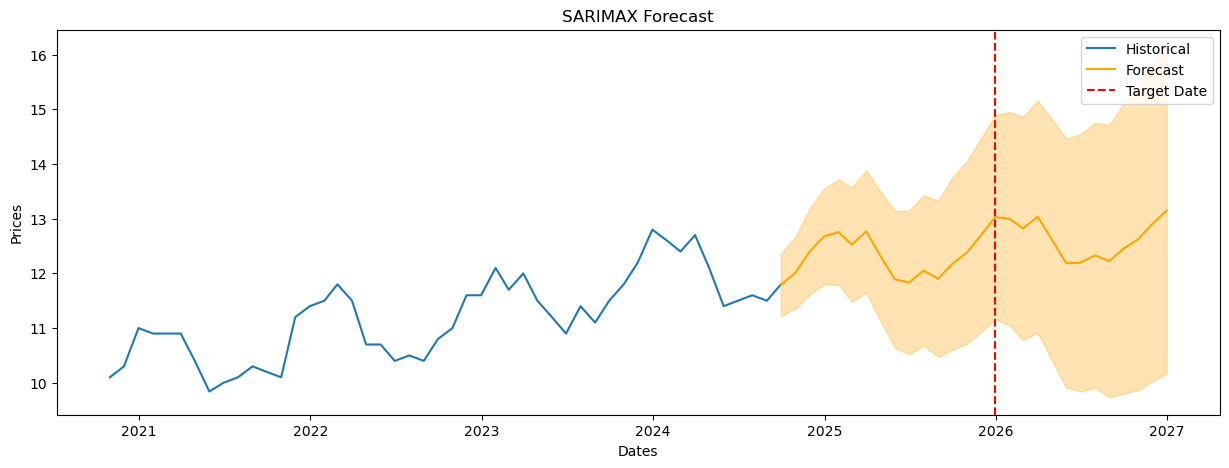

In [26]:
# Define the target date
target_date = pd.to_datetime('2025-12-31')

# Ensure date is beyond the training set
last_date = y_train.index[-1]
n_steps = (target_date.to_period('M') - last_date.to_period('M')).n + 1

# Forecast steps ahead
forecast = model.get_forecast(steps=n_steps)

# Extract forecasted values
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Get prediction for the target date
predicted_value = forecast_values[target_date]
conf_interval = forecast_conf_int.loc[target_date]

print(f"Predicted value for {target_date.date()}: {predicted_value:.2f}")
print(f"95% confidence interval: {conf_interval.values}")

forecast_index = forecast_values.index
plt.figure(figsize=(15, 5))
plt.plot(y, label='Historical')
plt.plot(forecast_values, label='Forecast', color='orange')
plt.fill_between(
    forecast_index,
    forecast_conf_int.iloc[:, 0],
    forecast_conf_int.iloc[:, 1],
    color='orange', alpha=0.3
)    
    
plt.axvline(target_date, color='red', linestyle='--', label='Target Date')
plt.legend()
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.title("SARIMAX Forecast")
plt.show()
